Carregar todas bibliotecas necessárias para execução do código:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score, ConfusionMatrixDisplay
import pandas as pd

Primeiro passo é extrair o CICIoT 2023, logo depois é processar o arquivo em chunks para criação do dataset com ataques de mirai e tráfego benigno que é nossa área de pesquisa:

In [2]:
import pandas as pd

# Caminho para o arquivo grande
file_path = "/home/michael/Mestrado/METODOS_QT/DatasetFull/CIC_IoT_Dataset_Unificado.csv"

# Caminho para o arquivo de saída
output_path = "/home/michael/Mestrado/METODOS_QT/DatasetFull/CIC_IoT_Dataset_Unificado_resumido.csv"

# Tamanho do chunk
chunk_size = 100000

# Inicializar um arquivo de saída vazio
with open(output_path, 'w') as output_file:
    # Processar o arquivo em chunks
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
        print(f"Processando chunk {i + 1}")
        
        # Filtrar dados que interessam (exemplo: manter apenas "Mirai" e "BenignTraffic")
        filtered_chunk = chunk[
            chunk['label'].str.contains('Mirai', regex=True) | 
            (chunk['label'] == 'BenignTraffic')
        ]
        
        if i == 0:
            # Escrever cabeçalho no primeiro chunk
            filtered_chunk.to_csv(output_file, index=False, mode='w')
        else:
            # Para chunks subsequentes, não incluir cabeçalho
            filtered_chunk.to_csv(output_file, index=False, mode='a', header=False)

print(f"Processo concluído. Dados filtrados salvos em {output_path}")


Processando chunk 1
Processando chunk 2
Processando chunk 3
Processando chunk 4
Processando chunk 5
Processando chunk 6
Processando chunk 7
Processando chunk 8
Processando chunk 9
Processando chunk 10
Processando chunk 11
Processando chunk 12
Processando chunk 13
Processando chunk 14
Processando chunk 15
Processando chunk 16
Processando chunk 17
Processando chunk 18
Processando chunk 19
Processando chunk 20
Processando chunk 21
Processando chunk 22
Processando chunk 23
Processando chunk 24
Processando chunk 25
Processando chunk 26
Processando chunk 27
Processando chunk 28
Processando chunk 29
Processando chunk 30
Processando chunk 31
Processando chunk 32
Processando chunk 33
Processando chunk 34
Processando chunk 35
Processando chunk 36
Processando chunk 37
Processando chunk 38
Processando chunk 39
Processando chunk 40
Processando chunk 41
Processando chunk 42
Processando chunk 43
Processando chunk 44
Processando chunk 45
Processando chunk 46
Processando chunk 47
Processando chunk 48
P

Carregar o novo dataset gerado com o procedimento realizado acima:

In [2]:
# Carregar o novo dataset
novo_dataset = pd.read_csv("/home/michael/Mestrado/METODOS_QT/DatasetFull/CIC_IoT_Dataset_Unificado_resumido.csv")

Identificação das colunas categóricas:

In [3]:
# Identificar colunas categóricas
categorical_columns = novo_dataset.select_dtypes(include=['object']).columns
print(f"Colunas categóricas: {categorical_columns.tolist()}")

Colunas categóricas: ['label']


Aplicar o LabelEncoder:

In [4]:


# Aplicar Label Encoding às colunas categóricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    novo_dataset[col] = le.fit_transform(novo_dataset[col])
    label_encoders[col] = le  # Armazenar o encoder para decodificação futura

Aplicar o ONEHOTENCONDING ***:

In [6]:
# Aplicar One-Hot Encoding
X = pd.get_dummies(novo_dataset, columns=categorical_columns)

Verificando a existência de valores NaN no dataset:

In [7]:
# Verificar colunas que possuem valores NaN (ausentes)
nan_columns = novo_dataset.columns[novo_dataset.isnull().any()]

# Exibir colunas com valores NaN e o número de valores ausentes em cada uma
if len(nan_columns) > 0:
    nan_info = novo_dataset[nan_columns].isnull().sum()
    print("Colunas com valores NaN (ausentes):")
    print(nan_info)
else:
    print("Nenhuma coluna possui valores NaN no dataset.")

Nenhuma coluna possui valores NaN no dataset.


Identificação e remoção de colunas que possuem apenas o valor 0

In [8]:
# Dropar todas as colunas que só contenham o valor 0.0 no dataset
zero_columns = novo_dataset.columns[(novo_dataset == 0.0).all()]

if len(zero_columns) > 0:
    print(f"As seguintes colunas possuem apenas valores 0.0 e serão removidas: {zero_columns.tolist()}")
    novo_dataset = novo_dataset.drop(columns=zero_columns)
else:
    print("Nenhuma coluna contém apenas valores 0.0 no dataset.")
    

As seguintes colunas possuem apenas valores 0.0 e serão removidas: ['Drate', 'ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP', 'SSH', 'IRC', 'DHCP']


Mapa de calor com todas as features após a remoção das colunas que continham apenas valores zero:

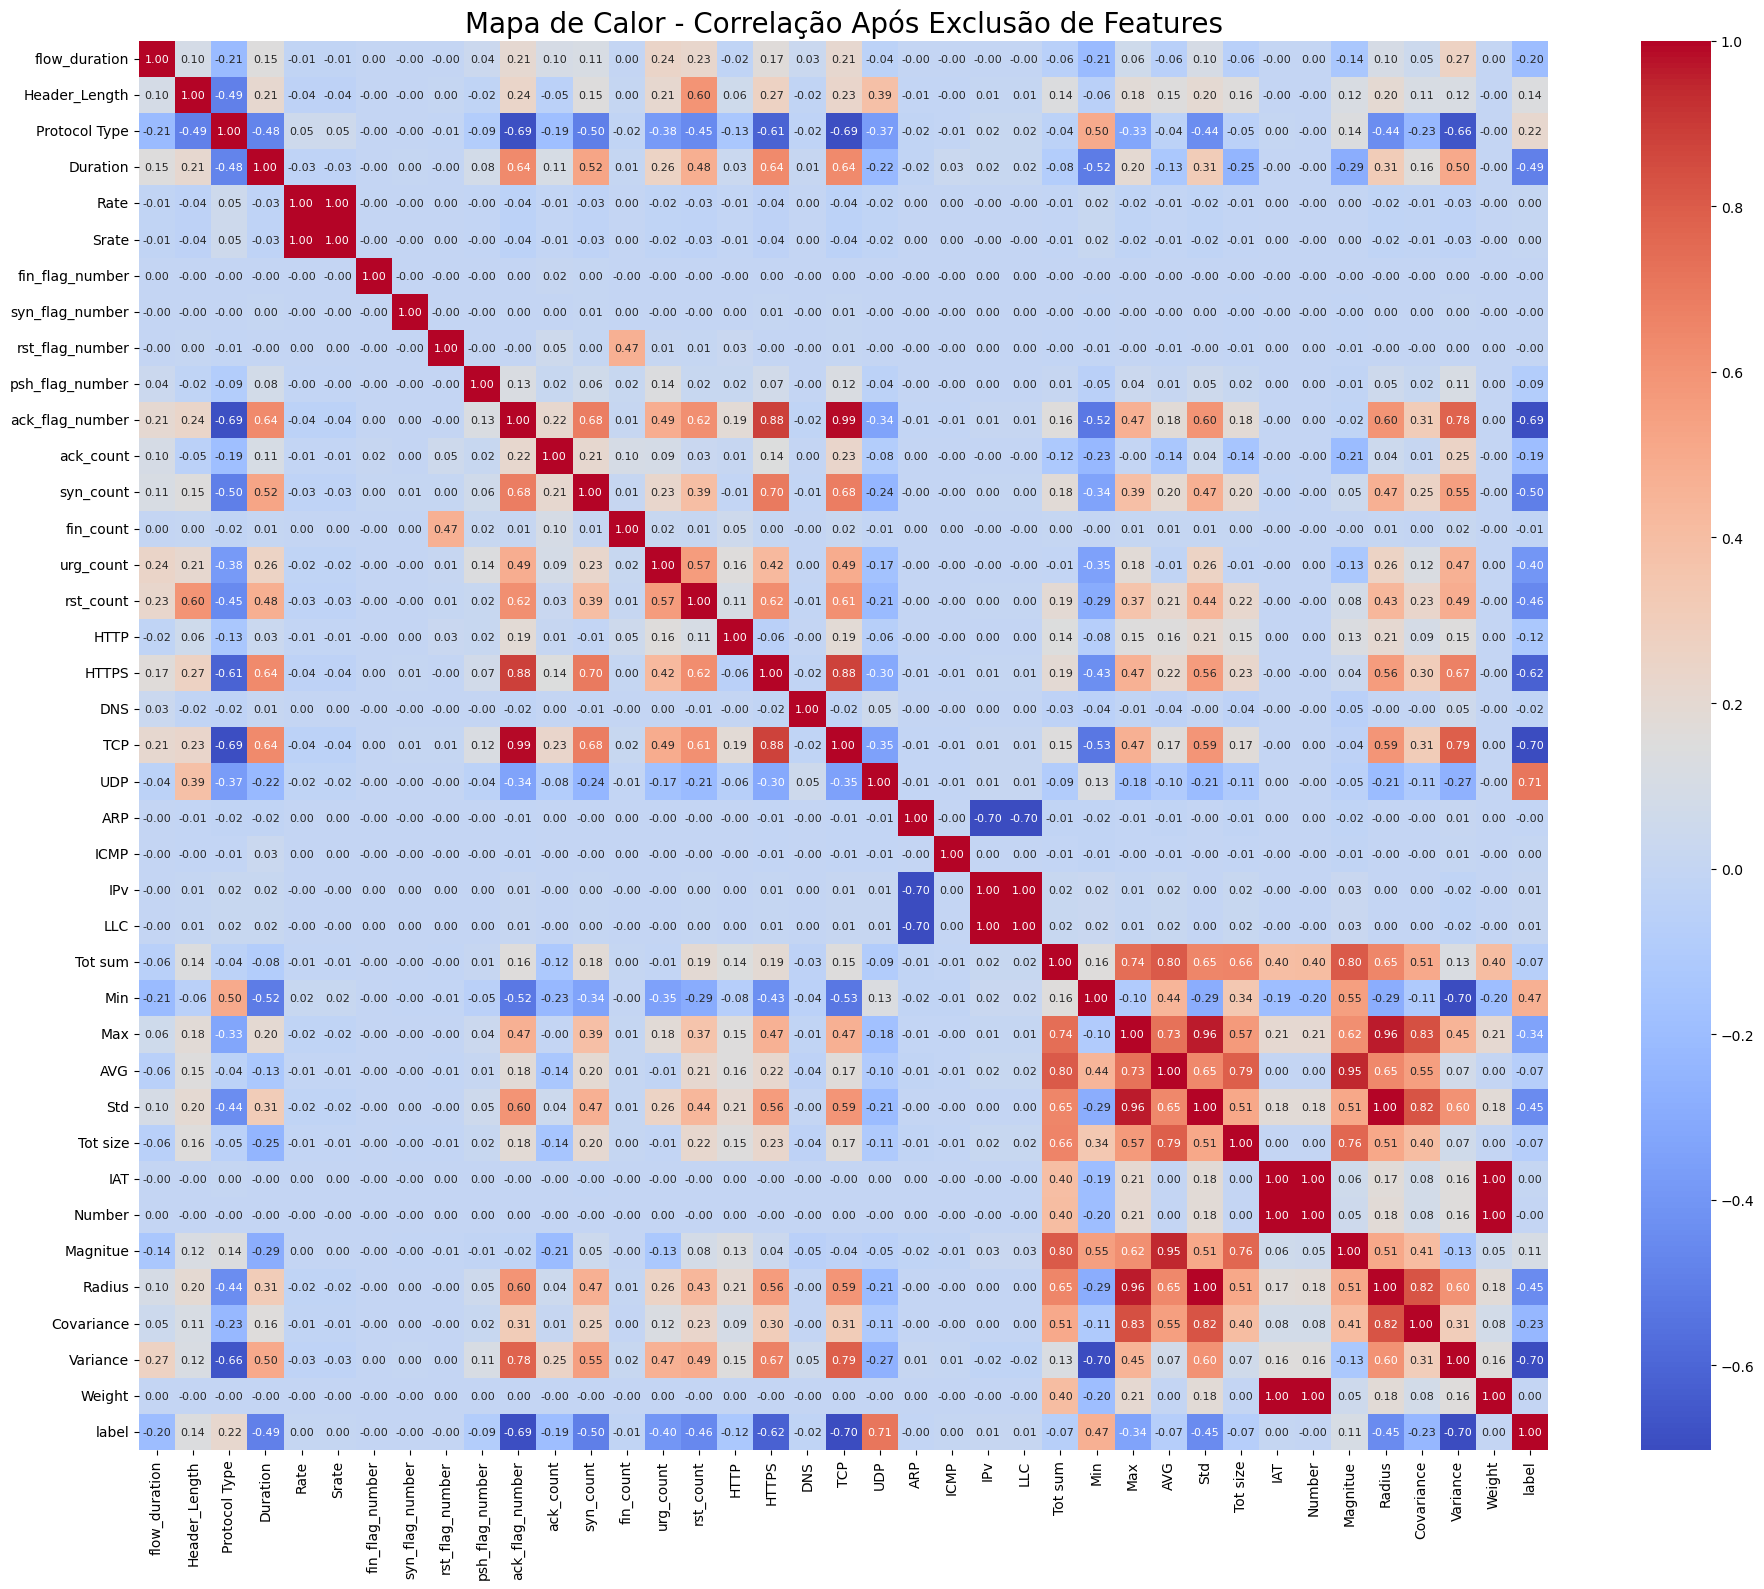

In [9]:



# Gerar o mapa de calor após a exclusão das features que continham apenas valores 0.0

# Recalcular a matriz de correlação
correlation_matrix = novo_dataset.corr()

# Configurar o tamanho da figura maior para melhor visualização
plt.figure(figsize=(20, 16))

# Gerar o mapa de calor
sns.heatmap(
    correlation_matrix,
    annot=True,       # Mostrar os valores no mapa
    fmt=".2f",        # Formatar os valores com duas casas decimais
    cmap="coolwarm",  # Escolher a paleta de cores
    cbar=True,        # Exibir a barra de cores
    square=True,      # Manter células quadradas
    annot_kws={"size": 8}  # Ajustar o tamanho das anotações
)

# Adicionar título e layout
plt.title("Mapa de Calor - Correlação Após Exclusão de Features", fontsize=20)
plt.tight_layout()

# Exibir o gráfico
plt.show()

Análise  baixa correlação e alta correlação e valores parecidos de correlação:

In [10]:
# Limite para correlação baixa com o label
low_correlation_threshold = 0.1

# Limite para alta correlação entre features
high_correlation_threshold = 0.85

# Identificar features com baixa correlação com o label
correlation_with_label = correlation_matrix["label"].drop("label")
low_correlation_features = correlation_with_label[correlation_with_label.abs() < low_correlation_threshold].index

print(f"Features com baixa correlação com o label (menor que {low_correlation_threshold}):")
print(low_correlation_features.tolist())

# Identificar pares de features altamente correlacionadas
high_correlation_pairs = []
for feature in correlation_matrix.columns:
    for other_feature in correlation_matrix.columns:
        if feature != other_feature and abs(correlation_matrix[feature][other_feature]) > high_correlation_threshold:
            high_correlation_pairs.append((feature, other_feature))

print("\nPares de features altamente correlacionadas (maior que 0.85):")
print(high_correlation_pairs)

# Opcional: Remover features redundantes ou com baixa correlação
features_to_remove = set(low_correlation_features)
for pair in high_correlation_pairs:
    # Remover apenas uma das features do par (exemplo: manter a primeira)
    if pair[1] not in features_to_remove:
        features_to_remove.add(pair[1])

print("\nFeatures sugeridas para remoção:")
print(features_to_remove)


Features com baixa correlação com o label (menor que 0.1):
['Rate', 'Srate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'fin_count', 'DNS', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'AVG', 'Tot size', 'IAT', 'Number', 'Weight']

Pares de features altamente correlacionadas (maior que 0.85):
[('Rate', 'Srate'), ('Srate', 'Rate'), ('ack_flag_number', 'HTTPS'), ('ack_flag_number', 'TCP'), ('HTTPS', 'ack_flag_number'), ('HTTPS', 'TCP'), ('TCP', 'ack_flag_number'), ('TCP', 'HTTPS'), ('IPv', 'LLC'), ('LLC', 'IPv'), ('Max', 'Std'), ('Max', 'Radius'), ('AVG', 'Magnitue'), ('Std', 'Max'), ('Std', 'Radius'), ('IAT', 'Number'), ('IAT', 'Weight'), ('Number', 'IAT'), ('Number', 'Weight'), ('Magnitue', 'AVG'), ('Radius', 'Max'), ('Radius', 'Std'), ('Weight', 'IAT'), ('Weight', 'Number')]

Features sugeridas para remoção:
{'fin_flag_number', 'DNS', 'ICMP', 'Number', 'Max', 'IPv', 'HTTPS', 'Srate', 'fin_count', 'Std', 'Radius', 'Weight', 'syn_flag_number', 'ARP', 'ack_fla

Remoção das features sugeridas e impressão do novo mapa de calor:

Features restantes no dataset após a remoção:
['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'ack_count', 'syn_count', 'urg_count', 'rst_count', 'HTTP', 'UDP', 'Min', 'Covariance', 'Variance', 'label']


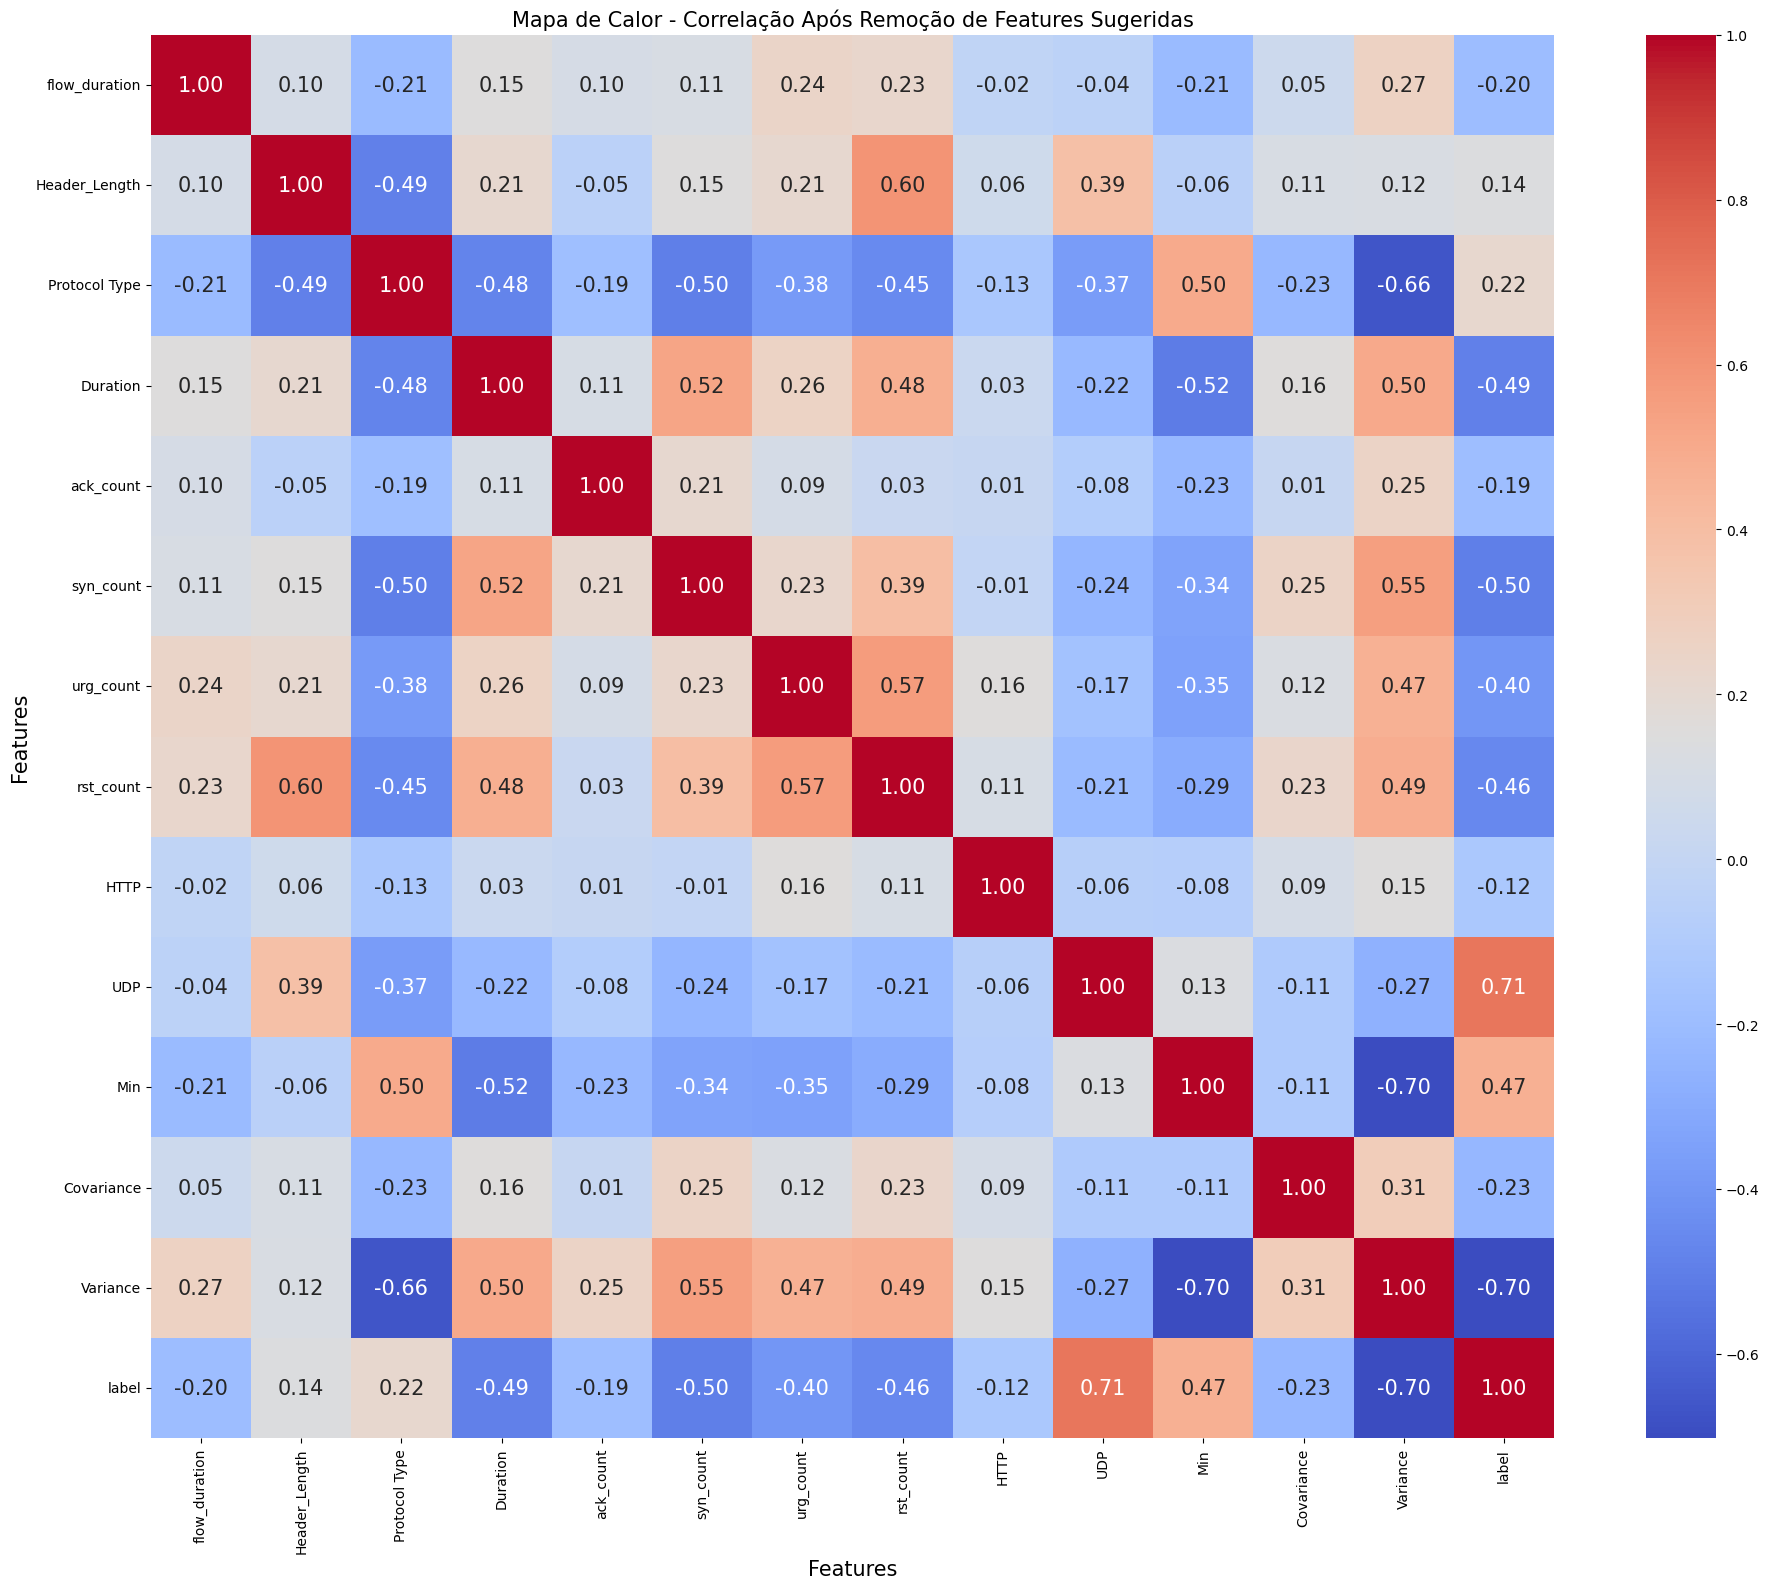

In [ ]:
# Remover as features sugeridas do dataset
features_to_remove = {'Radius', 'Srate', 'Max', 'AVG', 'LLC', 'DNS', 'fin_flag_number', 'IPv', 
                      'fin_count', 'Number', 'syn_flag_number', 'ICMP', 'Std', 'Weight', 'IAT', 
                      'Magnitue', 'psh_flag_number', 'ack_flag_number', 'ARP', 'Tot sum', 
                      'Rate', 'TCP', 'HTTPS', 'Tot size', 'rst_flag_number'}

# Verificar se as features a serem removidas estão no dataset
features_in_dataset = [feature for feature in features_to_remove if feature in novo_dataset.columns]

# Remover as features do dataset
novo_dataset = novo_dataset.drop(columns=features_in_dataset)

# Exibir as features restantes no dataset
print("Features restantes no dataset após a remoção:")
print(novo_dataset.columns.tolist())

# Recalcular o mapa de calor com as features restantes
correlation_matrix_updated = novo_dataset.corr()

# Configurar o tamanho da figura
plt.figure(figsize=(20, 16))

# Gerar o mapa de calor atualizado
sns.heatmap(
    correlation_matrix_updated,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    annot_kws={"size": 15}  # Tamanho das anotações
)

# Ajustar a fonte dos textos externos (título e rótulos dos eixos)
plt.title("Mapa de Calor - Correlação Após Remoção de Features Sugeridas", fontsize=15)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Features", fontsize=15)

# Ajustar o tamanho das fontes dos ticks nos eixos X e Y
plt.xticks(fontsize=12, rotation=45)  # Fonte maior e rotação para legibilidade
plt.yticks(fontsize=12)

# Ajustar espaçamento para evitar cortes
plt.tight_layout()

# Exibir o gráfico
plt.show()


Análise de dispersão da feature Duration: 

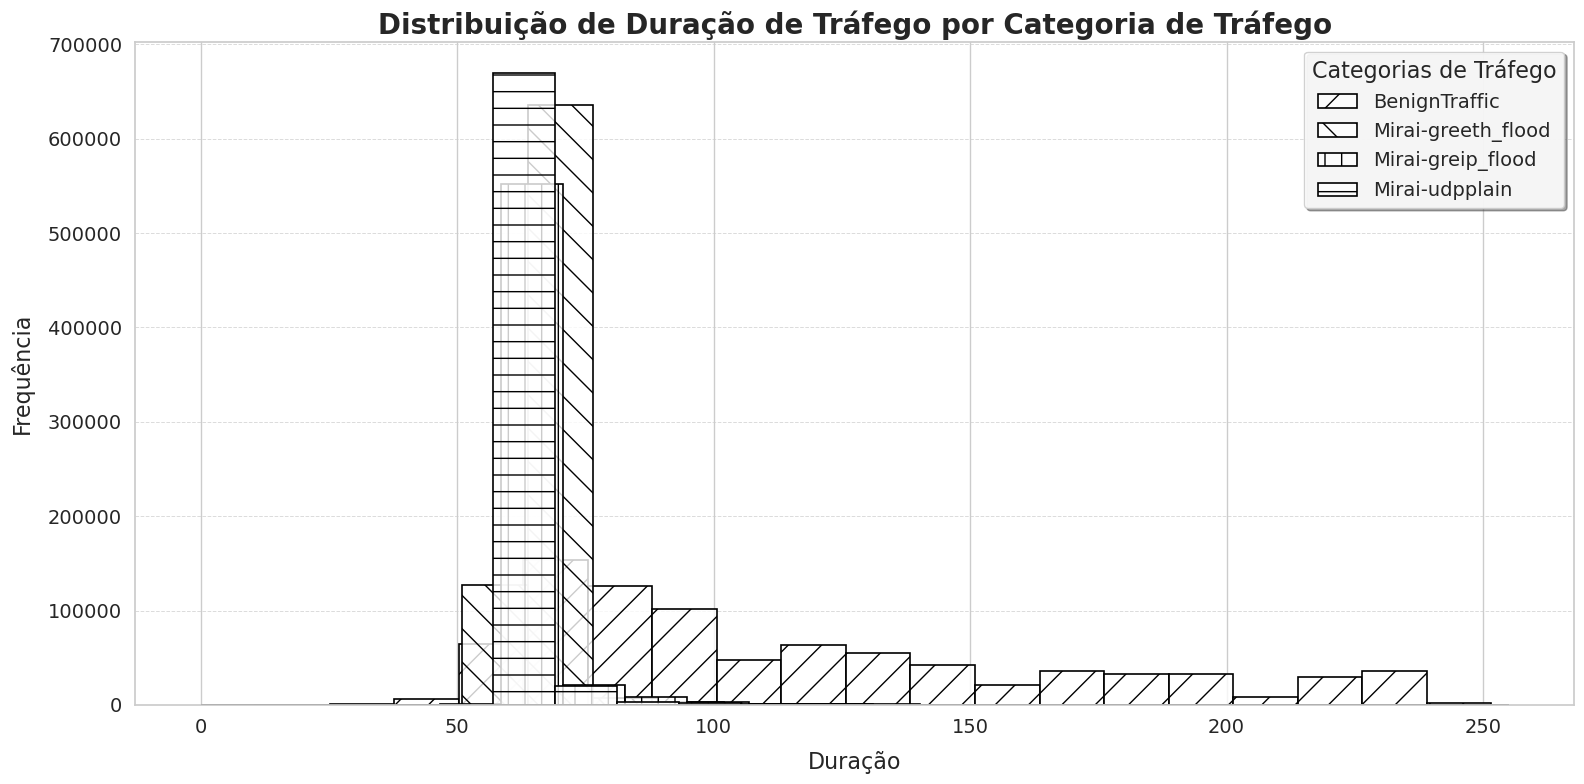

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Decodificar as classes (labels) usando o LabelEncoder armazenado
class_names = label_encoders['label'].inverse_transform(range(len(label_encoders['label'].classes_)))

# Configurar o estilo e a paleta de cores para preto, branco e hachuras
sns.set_theme(style="whitegrid")  # Aplicar um estilo mais limpo
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Padrões de hachuras diferentes

# Criar a figura
plt.figure(figsize=(16, 8))

# Plotar cada categoria de tráfego separadamente
for i, label in enumerate(range(len(class_names))):
    subset = novo_dataset[novo_dataset['label'] == label]
    sns.histplot(
        subset['Duration'], 
        kde=False,  # Remover a densidade para destacar as barras
        label=f"{class_names[label]}", 
        bins=20,  # Reduzir o número de bins para barras mais largas
        alpha=0.8, 
        color='white',  # Cor de preenchimento das barras (branco)
        edgecolor='black',  # Contorno das barras (preto)
        linewidth=1.2,  # Largura do contorno
        hatch=hatches[i % len(hatches)]  # Aplicar hachuras
    )

# Ajustar título e rótulos com fonte maior
plt.title("Distribuição de Duração de Tráfego por Categoria de Tráfego", fontsize=20, fontweight='bold')
plt.xlabel("Duração", fontsize=16, labelpad=10)
plt.ylabel("Frequência", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adicionar legenda com mais clareza
plt.legend(
    title="Categorias de Tráfego", 
    fontsize=14, 
    title_fontsize=16, 
    loc='upper right', 
    frameon=True, 
    framealpha=0.9, 
    shadow=True
)

# Ajustar limites do gráfico para evitar sobreposição
plt.ylim(0, None)  # Deixar o eixo Y começar em zero e ajustar automaticamente o topo

# Ajustar grades para melhor visualização
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Aplicar layout mais compacto
plt.tight_layout()

# Exibir o gráfico
plt.show()


Análise de dispersão da variável SYN_COUNT:

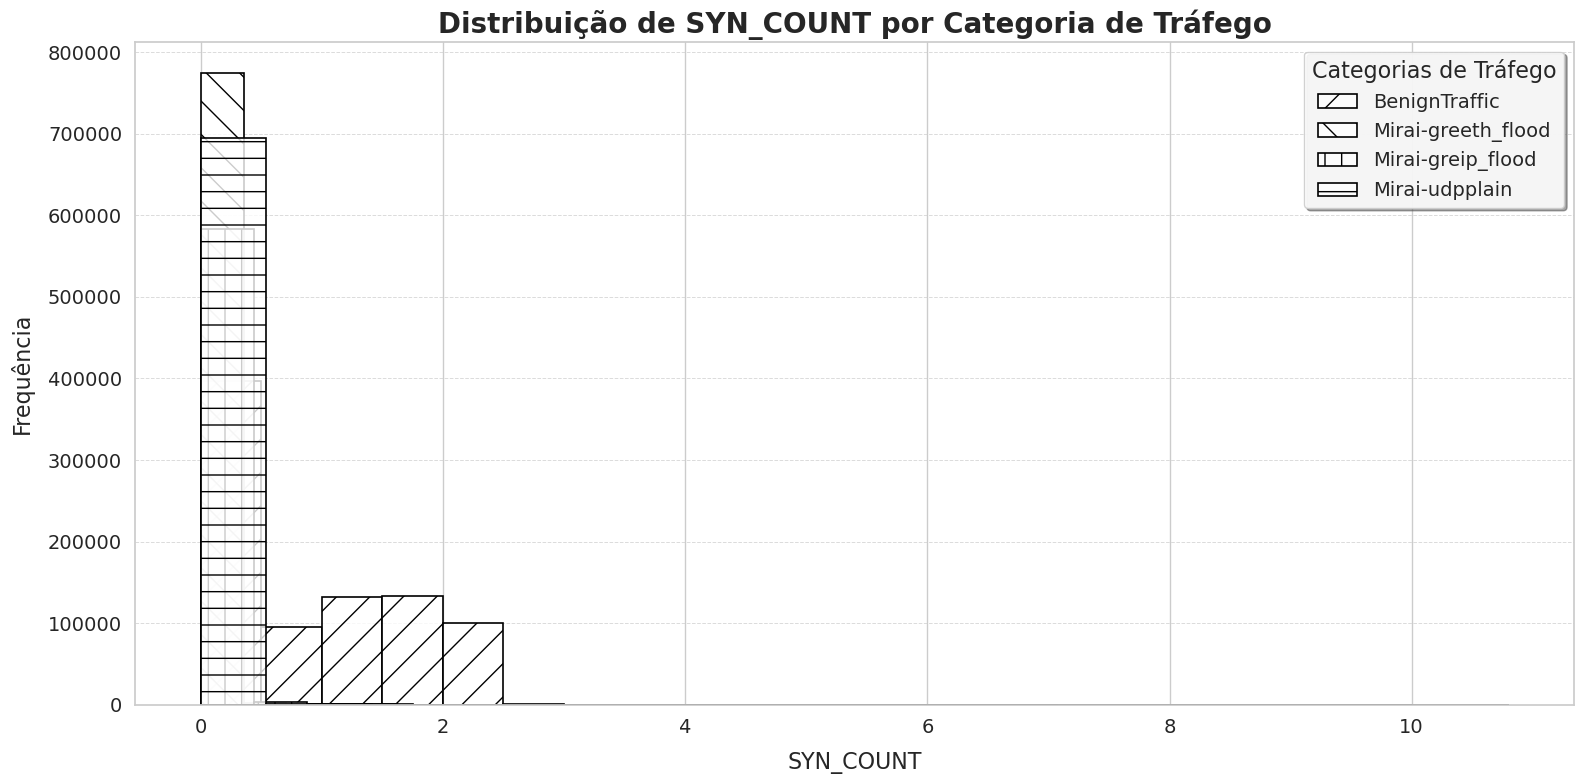

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decodificar as classes (labels) usando o LabelEncoder armazenado
class_names = label_encoders['label'].inverse_transform(range(len(label_encoders['label'].classes_)))

# Configurar o estilo e hachuras
sns.set_theme(style="whitegrid")  # Aplicar um estilo limpo
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Padrões de hachuras diferentes

# Criar a figura
plt.figure(figsize=(16, 8))

# Plotar cada categoria de tráfego separadamente
for i, label in enumerate(range(len(class_names))):
    subset = novo_dataset[novo_dataset['label'] == label]
    sns.histplot(
        subset['syn_count'], 
        kde=False,  # Remover KDE para destacar barras
        label=f"{class_names[label]}", 
        bins=20,  # Ajustar o número de bins
        alpha=0.8, 
        color='white',  # Cor das barras (branco)
        edgecolor='black',  # Contorno das barras (preto)
        linewidth=1.2,  # Largura do contorno
        hatch=hatches[i % len(hatches)]  # Aplicar hachuras
    )

# Ajustar título e rótulos com fontes maiores
plt.title("Distribuição de SYN_COUNT por Categoria de Tráfego", fontsize=20, fontweight='bold')
plt.xlabel("SYN_COUNT", fontsize=16, labelpad=10)
plt.ylabel("Frequência", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adicionar legenda
plt.legend(
    title="Categorias de Tráfego", 
    fontsize=14, 
    title_fontsize=16, 
    loc='upper right', 
    frameon=True, 
    framealpha=0.9, 
    shadow=True
)

# Ajustar limites e grades
plt.ylim(0, None)  # Ajustar o limite superior automaticamente
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Aplicar layout mais compacto
plt.tight_layout()

# Exibir o gráfico
plt.show()


Treinamento e aplicação do modelo RF:

In [14]:


# Separar as features e o label
X_rf = novo_dataset.drop(columns=['label'])
y_rf = novo_dataset['label']

# Dividir os dados em treino, validação e teste (70% treino, 15% validação, 15% teste)
X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(X_rf, y_rf, test_size=0.3, stratify=y_rf, random_state=42)
X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(X_temp_rf, y_temp_rf, test_size=0.5, stratify=y_temp_rf, random_state=42)

# Verificar os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(X_train_rf)}")
print(f"Tamanho do conjunto de validação: {len(X_val_rf)}")
print(f"Tamanho do conjunto de teste: {len(X_test_rf)}")

# Normalizar os dados com StandardScaler
scaler_rf = StandardScaler()

# Ajustar o scaler nos dados de treino e transformar os dados
X_train_scaled_rf = scaler_rf.fit_transform(X_train_rf)

# Apenas transformar (usar o scaler ajustado nos dados de treino) nos dados de validação e teste
X_val_scaled_rf = scaler_rf.transform(X_val_rf)
X_test_scaled_rf = scaler_rf.transform(X_test_rf)

# Criar e treinar o modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_scaled_rf, y_train_rf)

# Fazer previsões no conjunto de validação
y_val_pred_rf = model_rf.predict(X_val_scaled_rf)

# Calcular métricas no conjunto de validação
val_accuracy_rf = accuracy_score(y_val_rf, y_val_pred_rf)
val_precision_rf = precision_score(y_val_rf, y_val_pred_rf, average='weighted')
val_recall_rf = recall_score(y_val_rf, y_val_pred_rf, average='weighted')
val_f1_rf = f1_score(y_val_rf, y_val_pred_rf, average='weighted')
val_mse_rf = mean_squared_error(y_val_rf, y_val_pred_rf)
val_rmse_rf = np.sqrt(val_mse_rf)
val_r2_rf = r2_score(y_val_rf, y_val_pred_rf)

# Exibir métricas de validação
print(f"Validação - Accuracy: {val_accuracy_rf:.4f}")
print(f"Validação - Precision: {val_precision_rf:.4f}")
print(f"Validação - Recall: {val_recall_rf:.4f}")
print(f"Validação - F1-Score: {val_f1_rf:.4f}")
print(f"Validação - MSE: {val_mse_rf:.4f}")
print(f"Validação - RMSE: {val_rmse_rf:.4f}")
print(f"Validação - R2-Score: {val_r2_rf:.4f}")

# Fazer previsões no conjunto de teste
y_test_pred_rf = model_rf.predict(X_test_scaled_rf)

# Calcular métricas no conjunto de teste
test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
test_precision_rf = precision_score(y_test_rf, y_test_pred_rf, average='weighted')
test_recall_rf = recall_score(y_test_rf, y_test_pred_rf, average='weighted')
test_f1_rf = f1_score(y_test_rf, y_test_pred_rf, average='weighted')
test_mse_rf = mean_squared_error(y_test_rf, y_test_pred_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_r2_rf = r2_score(y_test_rf, y_test_pred_rf)

# Exibir métricas de teste
print("\nConjunto de Teste:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"Recall: {test_recall_rf:.4f}")
print(f"F1-Score: {test_f1_rf:.4f}")
print(f"MSE: {test_mse_rf:.4f}")
print(f"RMSE: {test_rmse_rf:.4f}")
print(f"R2-Score: {test_r2_rf:.4f}")

# Relatório completo no conjunto de teste
print("\nClassification Report - Conjunto de Teste:")
print(classification_report(y_test_rf, y_test_pred_rf))


Tamanho do conjunto de treino: 2047182
Tamanho do conjunto de validação: 438682
Tamanho do conjunto de teste: 438683
Validação - Accuracy: 0.9765
Validação - Precision: 0.9765
Validação - Recall: 0.9765
Validação - F1-Score: 0.9765
Validação - MSE: 0.0260
Validação - RMSE: 0.1611
Validação - R2-Score: 0.9801

Conjunto de Teste:
Accuracy: 0.9762
Precision: 0.9763
Recall: 0.9762
F1-Score: 0.9762
MSE: 0.0264
RMSE: 0.1624
R2-Score: 0.9797

Classification Report - Conjunto de Teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    129062
           1       0.96      0.95      0.96    116647
           2       0.94      0.95      0.94     88297
           3       1.00      1.00      1.00    104677

    accuracy                           0.98    438683
   macro avg       0.97      0.97      0.97    438683
weighted avg       0.98      0.98      0.98    438683



Plotagem das métricas de avaliação:

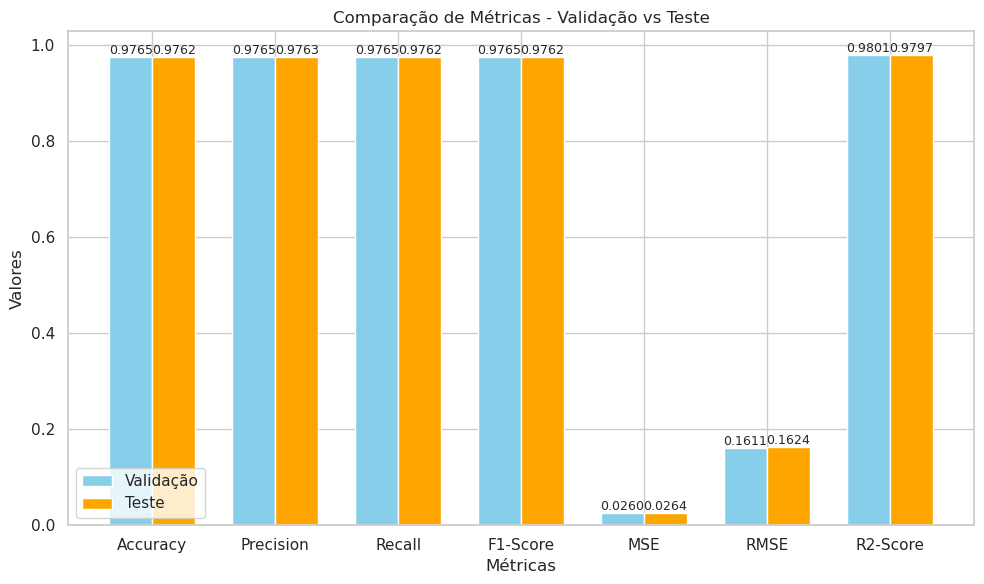

In [15]:


# Dados das métricas para validação e teste
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'RMSE', 'R2-Score']
validation_scores = [val_accuracy_rf, val_precision_rf, val_recall_rf, val_f1_rf, val_mse_rf, val_rmse_rf, val_r2_rf]
test_scores = [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf, test_mse_rf, test_rmse_rf, test_r2_rf]

# Criar o gráfico de barras para comparar as métricas
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, validation_scores, width, label='Validação', color='skyblue')
ax.bar([p + width for p in x], test_scores, width, label='Teste', color='orange')

# Adicionar rótulos e título
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas - Validação vs Teste')
ax.set_xticks([p + width/2 for p in x])
ax.set_xticklabels(metrics)
ax.legend()

# Adicionar rótulos nos topos das barras
for i in range(len(x)):
    ax.text(i, validation_scores[i], f"{validation_scores[i]:.4f}", ha='center', va='bottom', fontsize=9)
    ax.text(i + width, test_scores[i], f"{test_scores[i]:.4f}", ha='center', va='bottom', fontsize=9)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


Plotagem da matriz de confusão RF:

In [ ]:

# Recuperar o LabelEncoder do dicionário label_encoders
# Supondo que o nome da coluna original do label é 'label'
le_label = label_encoders['label']

# Gerar a matriz de confusão para o modelo Random Forest
conf_matrix_rf = confusion_matrix(y_test_rf, y_test_pred_rf)

# Recuperar os nomes originais das classes para o Random Forest
class_names_rf = [str(label) for label in le_label.inverse_transform(range(len(le_label.classes_)))]

# Exibir a matriz de confusão para o modelo LightGBM
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=class_names_rf)
disp_rf.plot(cmap="Blues", xticks_rotation='vertical', values_format=".0f")

# Adicionar título
plt.title("Matriz de Confusão - Random Forest", fontsize=16)

# Exibir o gráfico
plt.show()

Aplicação do modelo LIGHTGBM:

In [16]:


# Separar colunas categóricas e numéricas
categorical_columns = ['Protocol Type']  # Adicione todas as colunas categóricas aqui
numerical_columns = [col for col in novo_dataset.columns if col not in categorical_columns + ['label']]

# Aplicar Label Encoding às colunas categóricas
for col in categorical_columns:
    le = LabelEncoder()
    novo_dataset[col] = le.fit_transform(novo_dataset[col])

# Normalizar os dados numéricos
scaler = StandardScaler()
novo_dataset[numerical_columns] = scaler.fit_transform(novo_dataset[numerical_columns])

# Garantir que X e y estão definidos corretamente
X_lightgbm = novo_dataset.drop(columns=['label'])
y_lightgbm = novo_dataset['label']

# Codificar os rótulos (label)
label_encoder_lgbm = LabelEncoder()
y_lightgbm_encoded = label_encoder_lgbm.fit_transform(y_lightgbm)

# Dividir os dados em treino, validação e teste
X_train_lgbm, X_temp_lgbm, y_train_lgbm, y_temp_lgbm = train_test_split(X_lightgbm, y_lightgbm_encoded, test_size=0.3, stratify=y_lightgbm_encoded, random_state=42)
X_val_lgbm, X_test_lgbm, y_val_lgbm, y_test_lgbm = train_test_split(X_temp_lgbm, y_temp_lgbm, test_size=0.5, stratify=y_temp_lgbm, random_state=42)

# Criar datasets do LightGBM
train_data_lgbm = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
val_data_lgbm = lgb.Dataset(X_val_lgbm, label=y_val_lgbm, reference=train_data_lgbm)

# Parâmetros do modelo LightGBM
params_lgbm = {
    'objective': 'multiclass',
    'num_class': len(label_encoder_lgbm.classes_),
    'learning_rate': 0.1,
    'metric': 'multi_logloss',
    'random_state': 42
}

# Treinar o modelo LightGBM
model_lgbm = lgb.train(
    params_lgbm,
    train_data_lgbm,
    valid_sets=[val_data_lgbm],
    num_boost_round=100
)

# Fazer previsões no conjunto de teste
y_test_pred_proba_lgbm = model_lgbm.predict(X_test_lgbm)
y_test_pred_lgbm = y_test_pred_proba_lgbm.argmax(axis=1)  # Classe com maior probabilidade

# Avaliar o modelo LightGBM
accuracy_lgbm = accuracy_score(y_test_lgbm, y_test_pred_lgbm)
precision_lgbm = precision_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test_lgbm, y_test_pred_lgbm, average='weighted')

# Cálculo de métricas adicionais
mse_lgbm = mean_squared_error(y_test_lgbm, y_test_pred_lgbm)
rmse_lgbm = mse_lgbm ** 0.5
r2_lgbm = r2_score(y_test_lgbm, y_test_pred_lgbm)

# Exibir métricas
print("\nConjunto de Teste - LightGBM:")
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(f"Precision: {precision_lgbm:.4f}")
print(f"Recall: {recall_lgbm:.4f}")
print(f"F1-Score: {f1_lgbm:.4f}")
print(f"MSE: {mse_lgbm:.4f}")
print(f"RMSE: {rmse_lgbm:.4f}")
print(f"R2-Score: {r2_lgbm:.4f}")

# Relatório de classificação
print("\nClassification Report - LightGBM:")
class_names_lgbm = [str(label) for label in label_encoder_lgbm.classes_]
print(classification_report(y_test_lgbm, y_test_pred_lgbm, target_names=class_names_lgbm))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2523
[LightGBM] [Info] Number of data points in the train set: 2047182, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.223489
[LightGBM] [Info] Start training from score -1.324620
[LightGBM] [Info] Start training from score -1.603065
[LightGBM] [Info] Start training from score -1.432903

Conjunto de Teste - LightGBM:
Accuracy: 0.9758
Precision: 0.9759
Recall: 0.9758
F1-Score: 0.9758
MSE: 0.0259
RMSE: 0.1610
R2-Score: 0.9801

Classification Report - LightGBM:
              precision    recall  f1-score   support

           0       1.00      1.00      

Métricas do modelo LGBM:

In [ ]:


# Dados das métricas do LightGBM no conjunto de teste
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'RMSE', 'R2-Score']
values = [accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, mse_lgbm, rmse_lgbm, r2_lgbm]

# Configuração do gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue')

# Adicionar os valores no topo das barras
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.4f}", ha='center', va='bottom', fontsize=10)

# Personalização do gráfico
plt.title("Desempenho do Modelo LightGBM no Conjunto de Teste", fontsize=14)
plt.ylabel("Valores", fontsize=12)
plt.ylim(0, 1.1)  # Ajustar o limite do eixo Y
plt.xticks(rotation=45, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.tight_layout()
plt.show()


Matriz de confusão LGBM:

In [ ]:


# Gerar a matriz de confusão para o modelo LightGBM
conf_matrix_lgb = confusion_matrix(y_test_lgbm, y_test_pred_lgbm)

# Recuperar o LabelEncoder do dicionário label_encoders
# Supondo que o nome da coluna original do label é 'label'
le_label = label_encoders['label']

# Recuperar os nomes originais das classes para o LightGBM
class_names_lgb = [str(label) for label in le_label.inverse_transform(range(len(le_label.classes_)))]

# Exibir a matriz de confusão para o modelo LightGBM
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lgb, display_labels=class_names_lgb)
disp.plot(cmap="Blues", xticks_rotation='vertical', values_format=".0f")

# Adicionar título
plt.title("Matriz de Confusão - LightGBM", fontsize=16)

# Exibir o gráfico
plt.show()

Comparação RF X LGBM

In [ ]:


# Dados das métricas para Random Forest e LightGBM
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'R2-Score', 'MSE', 'RMSE', ]
rf_values = [test_accuracy_rf, test_precision_rf, test_recall_rf, test_f1_rf,test_r2_rf, test_mse_rf, test_rmse_rf ]
lgbm_values = [accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, r2_lgbm, mse_lgbm, rmse_lgbm ]

# Configuração do gráfico
x = np.arange(len(metrics))  # Posições das métricas no eixo X
width = 0.35  # Largura das barras

fig, ax = plt.subplots(figsize=(12, 6))

# Barras para Random Forest e LightGBM
bars_rf = ax.bar(x - width/2, rf_values, width, label='Random Forest', color='skyblue')
bars_lgbm = ax.bar(x + width/2, lgbm_values, width, label='LightGBM', color='orange')

# Adicionar valores no topo das barras
for bars in [bars_rf, bars_lgbm]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Personalização do gráfico
ax.set_title('Comparação de Desempenho: Random Forest vs LightGBM', fontsize=14)
ax.set_ylabel('Valores', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Exibir o gráfico
plt.tight_layout()
plt.show()
